In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma
import numpy as np
import scipy
import statsmodels
import geopandas as gp
from shapely.geometry import Point

In [4]:
slowzones = gp.GeoDataFrame.from_file("neighborhood_slow_zones.json")

In [5]:
slowzones

,Name,Shape_Leng,Year,geometry
0,New Brighton / St George SZ,13036.458032,2012,"POLYGON ((-74.08100100007188 40.6370809990848,..."
1,Corona SZ,10817.131818,2012,POLYGON ((-73.86942458231813 40.74915686824454...
2,Jackson Heights/East Elmhurst SZ,11114.722878,2013,"POLYGON ((-73.88713100050958 40.7648889990303,..."
3,Elmhurst SZ,12877.813210,2013,POLYGON ((-73.88207112111411 40.74782992580317...
4,Auburndale SZ,6477.631376,2013,POLYGON ((-73.78522788946755 40.76184569346055...
5,Inwood SZ,13491.829126,2012,POLYGON ((-73.91845699967485 40.87306999944159...
6,Baychester SZ,8972.379950,2013,"POLYGON ((-73.84640499958121 40.8770329992664,..."
7,Dongan Hills SZ,13195.014124,2013,POLYGON ((-74.09208699941692 40.58660899920393...
8,Eastchester SZ,8453.375658,2013,"POLYGON ((-73.8555370004179 40.87118899883096,..."
9,Riverdale SZ,11343.380217,2013,POLYGON ((-73.91713000028915 40.89255099941862...


In [22]:
slowzone_details = [
    (6, 2013),  #New Brighton, change to 2013.  Month uncertain?
    (6, 2013),  #Corona, change to 2013
    (4, 2013),  #Jackson Heights/East Elmhurst, 
    (3, 2013),  #Elmhurst Month Uncertain
    (6, 2013),  #Auburndale
    (9, 2012),  #Inwood
    (12, 2012), #Baychester
    (9, 2013),  #Dongan
    (10, 2012), #Eastchester
    (10, 2012), #Riverdale
    (2, 2013),  #Rosebank, Not right
    (7, 2012),  #MT Eden, Definitely not right
    (11, 2012), #Boerum
    (11, 2011), #Claremont*
    (6, 2014),  #Norwood, Month uncertain
    (8, 2014),  #Alphabet*
    None,       #Clinton Hill REMOVE
    (9, 2014),  #Jackson-Heights*
    None,       #Brownsville/East
    None,       #Hudson Heights REMOVE
    None,       #Parkchester REMOVE
    (8, 2015),  #Sunnyside Gardens-Woodside*
    (8,2015),   #Sunnyside*
    None,       #West Village REMOVE
    (10, 2015), #Prospect Heights*
    (10, 2015), #Brooklyn Heights*
    (9, 2015)    #Astoria*
]

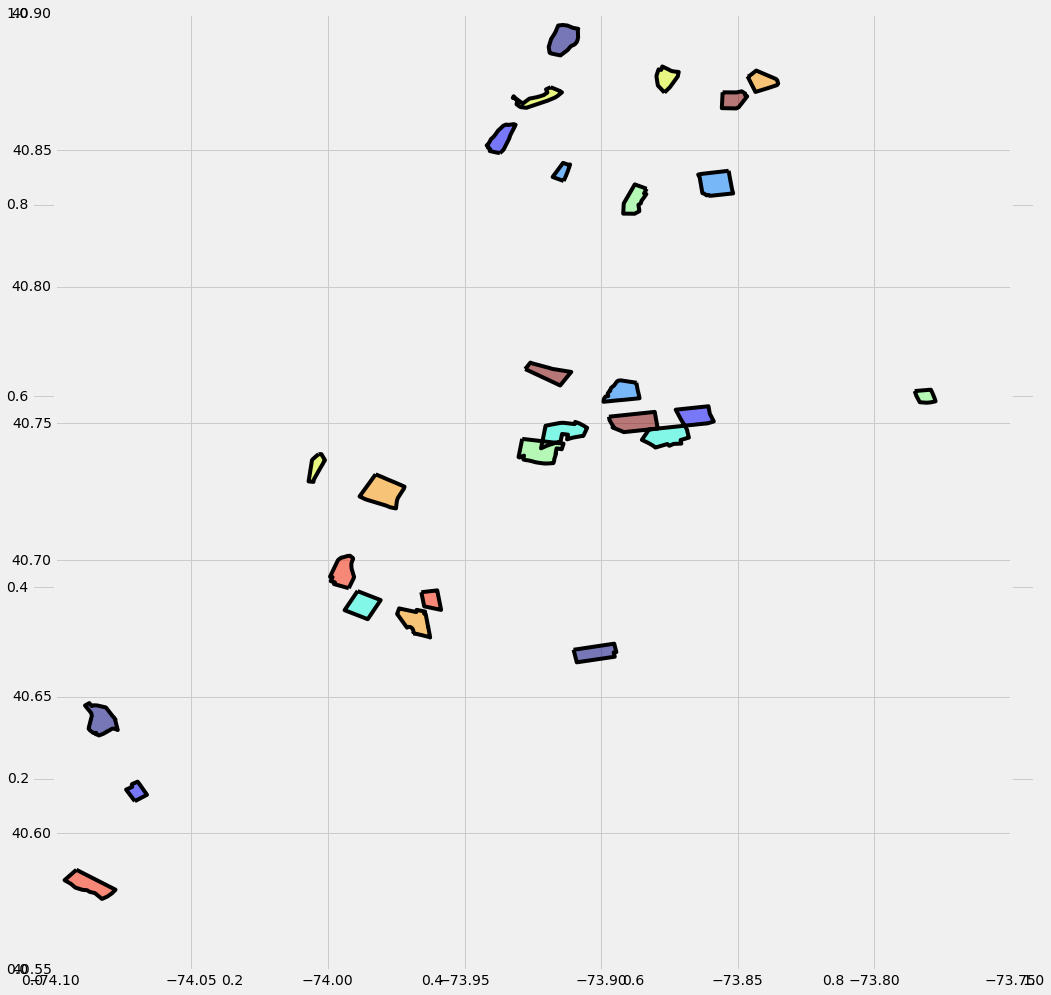

In [11]:
figure, ax = pl.subplots(figsize=(16,16))
slowzones.plot()

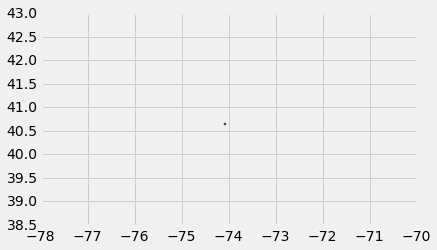

In [19]:
slowzones.intersection(Point(-74.08100100007188,40.6370809990848)).plot()

In [20]:
def convertDate(d):
    #dt = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    #dt = dt.replace(minute=(dt.minute / 20) * 10, second=0, microsecond=0)
    dt = datetime.datetime.strptime(d, '%m/%d/%Y')
    dt = dt.replace(day=1)
    #dt = dt - datetime.timedelta(hours=5)
    return dt

crashes = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv', converters={'DATE': convertDate})#, parse_dates=[1])

In [23]:
crashes.columns

Index([u'DATE', u'TIME', u'BOROUGH', u'ZIP CODE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION', u'ON STREET NAME', u'CROSS STREET NAME',
       u'OFF STREET NAME', u'NUMBER OF PERSONS INJURED',
       u'NUMBER OF PERSONS KILLED', u'NUMBER OF PEDESTRIANS INJURED',
       u'NUMBER OF PEDESTRIANS KILLED', u'NUMBER OF CYCLIST INJURED',
       u'NUMBER OF CYCLIST KILLED', u'NUMBER OF MOTORIST INJURED',
       u'NUMBER OF MOTORIST KILLED', u'CONTRIBUTING FACTOR VEHICLE 1',
       u'CONTRIBUTING FACTOR VEHICLE 2', u'CONTRIBUTING FACTOR VEHICLE 3',
       u'CONTRIBUTING FACTOR VEHICLE 4', u'CONTRIBUTING FACTOR VEHICLE 5',
       u'UNIQUE KEY', u'VEHICLE TYPE CODE 1', u'VEHICLE TYPE CODE 2',
       u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4', u'VEHICLE TYPE CODE 5'],
      dtype='object')

In [24]:
crashes['GEO'] = crashes.apply(lambda x: Point(x['LONGITUDE'], x['LATITUDE']), axis=1)